In [48]:
%matplotlib inline

In [1]:
import numpy as np
from scipy.linalg import norm, lstsq

# Orthogonal matching pursuit (OMP)
def OMP(A, b, delta=1e-6, maxnnz=None):
    m, n = A.shape
    if maxnnz is None: maxnnz = m // 2
    r = b.copy()
    x = np.zeros(n, dtype=b.dtype)
    supp = []
    while len(supp) < maxnnz and norm(r) > delta:
        s = np.argmax(np.abs(A.T.dot(r)))
        supp.append(s)
        Asupp = A[:,supp]
        x[supp] = lstsq(Asupp, b)[0]
        r = b - Asupp.dot(x[supp])
    return x

In [2]:
from time import time
# Generate sythetic data for demo
rng = np.random.RandomState(int(time()))
#m, n = 128, 256
#m, n = 256, 512
#m, n = 512, 2048
#m, n = 1024, 8192
m, n = 2000, 4000
dtype = np.float64  # try np.float32 and np.float64

# use a random matrix as a basis
A = rng.randn(m, n).astype(dtype) / np.sqrt(m)

# generate a k-sparse Gaussian signal vector
k = 300
stdx = 1.
snr = 10.  # try 20., 10., 5., np.inf

x_true = np.zeros(n, dtype=dtype)
T = np.sort(rng.choice(n,k,replace=False))
print('True support of %d nonzeros = ' % (k))
print(T)
x_true[T] = rng.randn(k).astype(dtype) * stdx

# make the query vector
b = A.dot(x_true)

# add noise
if np.isinf(snr):
    noise = 0.
else:
    normb = norm(b)
    noise = rng.randn(m).astype(dtype)
    noise = noise / norm(noise) * normb / snr
    b = b + noise

tol = norm(noise)

True support of 300 nonzeros = 
[   8   25   31   37   58   71   98  137  152  183  207  217  221  225  242
  252  254  257  279  284  288  298  301  347  352  356  366  386  387  413
  452  454  501  517  524  532  549  555  565  571  575  580  583  587  594
  615  619  623  630  641  652  655  657  674  704  710  716  722  725  735
  737  738  753  763  764  782  791  792  798  855  859  891  903  946  950
  953  956  963  974  995 1049 1051 1062 1093 1111 1149 1158 1164 1166 1168
 1185 1201 1215 1239 1243 1257 1278 1296 1311 1316 1321 1350 1375 1391 1395
 1427 1455 1467 1494 1512 1521 1532 1545 1555 1564 1577 1581 1583 1595 1598
 1607 1615 1622 1643 1648 1659 1688 1696 1719 1776 1799 1809 1817 1854 1862
 1868 1877 1883 1889 1897 1899 1907 1924 1928 1952 1961 1968 1979 1987 1996
 2000 2016 2033 2048 2062 2072 2093 2096 2104 2124 2127 2131 2137 2168 2185
 2200 2222 2240 2251 2259 2275 2317 2321 2334 2370 2383 2390 2392 2393 2394
 2403 2469 2497 2504 2505 2516 2528 2589 2592 2597 2598 

In [3]:
# OMP
print("Running OMP..")
t0 = time()
x_est = OMP(A, b, delta=tol)
#x_est = OMP(A, b)  # noiseless case (snr=np.inf)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running OMP..
done in 4.02s.
Predicted supprt of 254 nonzeros = 
[   8   25   37   58   71   98  137  207  217  221  242  252  254  257  279
  284  288  298  301  352  356  366  386  387  413  452  454  501  517  549
  555  565  575  583  587  594  615  619  623  630  641  652  655  657  704
  710  716  722  725  735  737  738  753  763  764  782  791  792  798  855
  859  891  903  946  956  963  974  995 1051 1062 1093 1111 1149 1158 1166
 1168 1185 1201 1239 1243 1257 1296 1311 1316 1350 1375 1391 1395 1427 1455
 1467 1494 1512 1521 1532 1545 1555 1564 1577 1581 1598 1607 1615 1622 1643
 1688 1719 1799 1809 1817 1854 1862 1883 1897 1899 1907 1924 1928 1952 1968
 1979 1987 2000 2033 2048 2062 2072 2093 2096 2104 2124 2127 2131 2137 2168
 2185 2222 2259 2275 2317 2321 2334 2370 2383 2390 2392 2394 2403 2504 2505
 2516 2528 2589 2592 2597 2598 2613 2622 2633 2634 2647 2650 2660 2671 2674
 2688 2691 2714 2739 2758 2771 2789 2809 2818 2824 2832 2835 2848 2852 2871
 2873 2893 2908 2937 29

In [4]:
import numpy as np
from scipy.linalg import norm, qr_insert, solve_triangular

# Orthogonal matching pursuit with QR factorization (OMPQR)
def OMPQR(A, b, delta=1e-6, maxnnz=None):
    m, n = A.shape
    if maxnnz is None: maxnnz = m // 2
    r = b.copy()

    # find the 1st atom and orthonormal basis
    s = np.argmax(np.abs(A.T.dot(r)))
    R = np.atleast_2d(norm(A[:,s])).astype(A.dtype)
    Q = np.atleast_2d(A[:,s] / R).astype(A.dtype).T
    xi = Q[:,-1].dot(b)
    r -= xi * Q[:,-1]
    xnz = [xi]
    supp = [s]

    while len(supp) < maxnnz and norm(r) > delta:
        s = np.argmax(np.abs(A.T.dot(r)))
        Q, R = qr_insert(Q, R, A[:,s], Q.shape[1], which='col')
        xi = Q[:,-1].dot(b)
        r -= xi * Q[:,-1]
        xnz.append(xi)
        supp.append(s)

    xnz = solve_triangular(R, xnz)
    x = np.zeros(n)
    x[supp] = xnz
    return x

In [5]:
# OMPQR
print("Running OMPQR..")
t0 = time()
x_est = OMPQR(A, b, delta=tol)
#x_est = OMPQR(A, b)  # noiseless case (snr=np.inf)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running OMPQR..
done in 1.25s.
Predicted supprt of 254 nonzeros = 
[   8   25   37   58   71   98  137  207  217  221  242  252  254  257  279
  284  288  298  301  352  356  366  386  387  413  452  454  501  517  549
  555  565  575  583  587  594  615  619  623  630  641  652  655  657  704
  710  716  722  725  735  737  738  753  763  764  782  791  792  798  855
  859  891  903  946  956  963  974  995 1051 1062 1093 1111 1149 1158 1166
 1168 1185 1201 1239 1243 1257 1296 1311 1316 1350 1375 1391 1395 1427 1455
 1467 1494 1512 1521 1532 1545 1555 1564 1577 1581 1598 1607 1615 1622 1643
 1688 1719 1799 1809 1817 1854 1862 1883 1897 1899 1907 1924 1928 1952 1968
 1979 1987 2000 2033 2048 2062 2072 2093 2096 2104 2124 2127 2131 2137 2168
 2185 2222 2259 2275 2317 2321 2334 2370 2383 2390 2392 2394 2403 2504 2505
 2516 2528 2589 2592 2597 2598 2613 2622 2633 2634 2647 2650 2660 2671 2674
 2688 2691 2714 2739 2758 2771 2789 2809 2818 2824 2832 2835 2848 2852 2871
 2873 2893 2908 2937 

In [6]:
import numpy as np
from scipy.linalg import norm, lstsq

# Generalized orthogonal matching pursuit (gOMP)
def gOMP(A, b, N=3, delta=1e-6, maxiter=None, maxnnz=None):
    m, n = A.shape
    if maxiter is None: maxiter = m // N
    r = b.copy()
    x = np.zeros(n, dtype=b.dtype)
    supp = []
    #supp = np.array([], dtype=int)

    count = 0
    while count < maxiter and norm(r) > delta:
        count += 1
        s = np.argsort(-np.abs(A.T.dot(r)))
        supp.extend(s[:N])
        #supp = np.union1d(supp, s[:N])
        Asupp = A[:,supp]
        x[supp] = lstsq(Asupp, b)[0]
        r = b - Asupp.dot(x[supp])
    if maxnnz is not None and len(supp) > maxnnz:
        x[np.argsort(-np.abs(x))[maxnnz:]] = 0.
    return x

In [9]:
# gOMP
print("Running gOMP..")
t0 = time()
x_est = gOMP(A, b, N=6, delta=tol)
#x_est = gOMP(A, b, N=6)  # noiseless case (snr=np.inf)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running gOMP..
done in 0.78s.
Predicted supprt of 258 nonzeros = 
[   8   25   31   37   58   71   98  137  207  217  221  242  252  254  257
  279  284  288  298  301  352  356  366  386  387  413  452  454  501  517
  524  549  555  565  575  583  587  594  615  619  623  630  641  652  655
  657  704  710  716  722  725  735  737  738  753  763  764  782  791  792
  798  855  859  891  903  946  956  963  974  995 1051 1062 1093 1111 1149
 1158 1166 1168 1185 1201 1239 1243 1257 1296 1311 1316 1350 1375 1391 1395
 1427 1455 1467 1494 1512 1521 1532 1545 1555 1564 1577 1581 1598 1607 1615
 1622 1643 1648 1688 1719 1799 1809 1817 1854 1862 1883 1897 1899 1907 1924
 1928 1952 1968 1979 1987 2000 2016 2033 2048 2062 2072 2093 2096 2104 2124
 2127 2131 2137 2168 2185 2222 2259 2275 2317 2321 2334 2370 2383 2390 2392
 2394 2403 2504 2505 2516 2528 2589 2592 2597 2598 2613 2622 2633 2634 2647
 2650 2660 2671 2674 2688 2691 2714 2739 2758 2771 2789 2809 2818 2824 2832
 2835 2848 2852 2871 2

In [10]:
import numpy as np
from scipy.linalg import norm, qr, qr_insert, solve_triangular

# Generalized orthogonal matching pursuit with QR factorization (gOMPQR)
def gOMPQR(A, b, N=3, delta=1e-6, maxiter=None, maxnnz=None):
    m, n = A.shape
    if maxiter is None: maxiter = m // N
    r = b.copy()

    # find the 1st atom group and orthonormal basis
    s = np.argsort(-np.abs(A.T.dot(r)))
    Q, R = qr(A[:,s[:N]], mode='economic')
    xi = Q.T.dot(b)
    r -= Q.dot(xi)
    xnz = xi.tolist()
    supp = s[:N].tolist()
    
    count = 1
    while count < maxiter and norm(r) > delta:
        count += 1
        s = np.argsort(-np.abs(A.T.dot(r)))
        Q, R = qr_insert(Q, R, A[:,s[:N]], Q.shape[1], which='col')
        xi = Q[:,-N:].T.dot(b)
        r -= Q[:,-N:].dot(xi)
        xnz.extend(xi)
        supp.extend(s[:N])

    xnz = solve_triangular(R, xnz)
    x = np.zeros(n)
    x[supp] = xnz
    if maxnnz is not None and len(supp) > maxnnz:
        x[np.argsort(-np.abs(x))[maxnnz:]] = 0.
    return x

In [12]:
# gOMPQR
print("Running gOMPQR..")
t0 = time()
x_est = gOMPQR(A, b, N=6, delta=tol)
#x_est = gOMPQR(A, b, N=6, maxiter=min(k,m//6), maxnnz=k)
#x_est = gOMPQR(A, b, N=6)  # noiseless case (snr=np.inf)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running gOMPQR..
done in 0.27s.
Predicted supprt of 258 nonzeros = 
[   8   25   31   37   58   71   98  137  207  217  221  242  252  254  257
  279  284  288  298  301  352  356  366  386  387  413  452  454  501  517
  524  549  555  565  575  583  587  594  615  619  623  630  641  652  655
  657  704  710  716  722  725  735  737  738  753  763  764  782  791  792
  798  855  859  891  903  946  956  963  974  995 1051 1062 1093 1111 1149
 1158 1166 1168 1185 1201 1239 1243 1257 1296 1311 1316 1350 1375 1391 1395
 1427 1455 1467 1494 1512 1521 1532 1545 1555 1564 1577 1581 1598 1607 1615
 1622 1643 1648 1688 1719 1799 1809 1817 1854 1862 1883 1897 1899 1907 1924
 1928 1952 1968 1979 1987 2000 2016 2033 2048 2062 2072 2093 2096 2104 2124
 2127 2131 2137 2168 2185 2222 2259 2275 2317 2321 2334 2370 2383 2390 2392
 2394 2403 2504 2505 2516 2528 2589 2592 2597 2598 2613 2622 2633 2634 2647
 2650 2660 2671 2674 2688 2691 2714 2739 2758 2771 2789 2809 2818 2824 2832
 2835 2848 2852 2871

rel. error = 5.80e-02


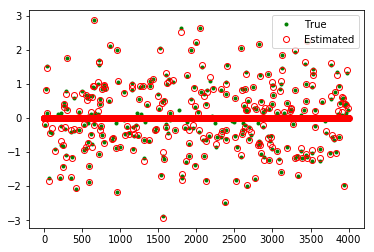

In [14]:
print('rel. error = %.2e' % (norm(x_est-x_true)/norm(x_true)))
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(n), x_true, 'g.', markersize=6, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=6, mec='red', mew=1, label='Estimated')
plt.legend(loc='upper right', shadow=False)
plt.show()

In [57]:
%timeit -r 4 -n 10 gOMPQR(A, b, N=3,delta=tol)

10 loops, best of 4: 2.87 ms per loop


In [138]:
m, n = 512, 1024
#m, n = 128, 256
reconsts = {'test_count': 0, 'shape': (m,n), 'nnz': range(5, m//2, 10)}
for alg in ['OMP', 'gOMP3', 'gOMP6', 'gOMP9']:
    reconsts[alg] = {'success': {}, 'time': {}}
    for k in reconsts['nnz']:
        reconsts[alg]['success'][k] = 0
        reconsts[alg]['time'][k] = 0
print(reconsts)

{'test_count': 0, 'shape': (512, 1024), 'nnz': range(5, 256, 10), 'OMP': {'success': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0, 105: 0, 115: 0, 125: 0, 135: 0, 145: 0, 155: 0, 165: 0, 175: 0, 185: 0, 195: 0, 205: 0, 215: 0, 225: 0, 235: 0, 245: 0, 255: 0}, 'time': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0, 105: 0, 115: 0, 125: 0, 135: 0, 145: 0, 155: 0, 165: 0, 175: 0, 185: 0, 195: 0, 205: 0, 215: 0, 225: 0, 235: 0, 245: 0, 255: 0}}, 'gOMP3': {'success': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0, 105: 0, 115: 0, 125: 0, 135: 0, 145: 0, 155: 0, 165: 0, 175: 0, 185: 0, 195: 0, 205: 0, 215: 0, 225: 0, 235: 0, 245: 0, 255: 0}, 'time': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85: 0, 95: 0, 105: 0, 115: 0, 125: 0, 135: 0, 145: 0, 155: 0, 165: 0, 175: 0, 185: 0, 195: 0, 205: 0, 215: 0, 225: 0, 235: 0, 245: 0, 255: 0}}, 'gOMP6': {'success': {5: 0, 15: 0, 25: 0, 35: 0, 45: 0, 55: 0, 65: 0, 75: 0, 85:

In [ ]:
from sklearn import metrics


print(reconsts['nnz'])
stdx = 1.
snr = np.inf  # try 20., 10., 5.
rng = np.random.RandomState(int(time()))
dtype = np.float64  # try np.float32 and np.float64

def count_success(x_true, x_est, reconsts, alg, k):
    cf = metrics.confusion_matrix(x_true == 0, x_est == 0)
    if cf[1,0] == 0 and cf[0,1] == 0:
        reconsts[alg]['success'][k] += 1

ntests = 100
reconsts['test_count'] += ntests
for k in reconsts['nnz']:

    x_true = np.zeros(n, dtype=dtype)
    T = np.sort(rng.choice(n,k,replace=False))
    # print('True support of %d nonzeros = ' % (k))
    x_true[T] = rng.randn(k).astype(dtype) * stdx

    for t in range(ntests):
        # use a random matrix as a basis
        A = rng.randn(m, n).astype(dtype) / np.sqrt(m)

        # make the query vector
        b = A.dot(x_true)

        # add noise
        if np.isinf(snr):
            noise = 0.
        else:
            normb = norm(b)
            noise = rng.randn(m).astype(dtype)
            noise = noise / norm(noise) * normb / snr
            b = b + noise
    
        tol = norm(noise)
        
        t0 = time()   
        x_est = gOMPQR(A, b, N=1, maxnnz=k, maxiter=k, delta=norm(b)*1e-8)
        reconsts['OMP']['time'][k] += time() - t0
        count_success(x_true, x_est, reconsts, 'OMP', k)

        t0 = time()   
        x_est = gOMPQR(A, b, N=3, maxnnz=k, maxiter=min(k, m//3), delta=norm(b)*1e-8)
        reconsts['gOMP3']['time'][k] += time() - t0
        count_success(x_true, x_est, reconsts, 'gOMP3', k)

        t0 = time()   
        x_est = gOMPQR(A, b, N=6, maxnnz=k, maxiter=min(k, m//6), delta=norm(b)*1e-8)
        reconsts['gOMP6']['time'][k] += time() - t0
        count_success(x_true, x_est, reconsts, 'gOMP6', k)

        t0 = time()   
        x_est = gOMPQR(A, b, N=9, maxnnz=k, maxiter=min(k, m//9), delta=norm(b)*1e-8)
        reconsts['gOMP9']['time'][k] += time() - t0
        count_success(x_true, x_est, reconsts, 'gOMP9', k)


range(5, 256, 10)


In [ ]:
import matplotlib.pyplot as plt
plt.figure()

reconst = np.array(list(reconsts['OMP']['success'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst, 'ko-.', markersize=6, mec='k', mfc='None', label='OMP')

reconst = np.array(list(reconsts['gOMP3']['success'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst, 'ks-', markersize=6, mec='k', mfc='None', label='gOMP (N=3)')

reconst = np.array(list(reconsts['gOMP6']['success'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst, 'k*-', markersize=8, mec='k', mfc='None', label='gOMP (N=6)')

reconst = np.array(list(reconsts['gOMP9']['success'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst, 'k>-', markersize=6, mec='k', mfc='None', label='gOMP (N=9)')

#plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=8, mec='red', mew=1, label='Estimated')
plt.legend(loc='lower left', shadow=False)
plt.title('#trials='+str(reconsts['test_count']), fontsize=16)
plt.xlabel("Sparsity", fontsize=16)
plt.ylabel("Prob. of exact reconst.", fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)

plt.tight_layout()
plt.savefig('gOMP_prob_reconst.pdf', bbox_inches='tight', dpi=300)
plt.savefig('gOMP_prob_reconst.eps', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
#plt.yscale("log")
from matplotlib.ticker import ScalarFormatter

reconst = np.array(list(reconsts['OMP']['time'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst*1000, 'ko-.', markersize=6, mec='k', mfc='None', label='OMP')

reconst = np.array(list(reconsts['gOMP3']['time'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst*1000, 'ks-', markersize=6, mec='k', mfc='None', label='gOMP (N=3)')

reconst = np.array(list(reconsts['gOMP6']['time'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst*1000, 'k*-', markersize=8, mec='k', mfc='None', label='gOMP (N=6)')

reconst = np.array(list(reconsts['gOMP9']['time'].values())) / reconsts['test_count']
plt.plot(reconsts['nnz'], reconst*1000, 'k>-', markersize=6, mec='k', mfc='None', label='gOMP (N=9)')

#plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=8, mec='red', mew=1, label='Estimated')
plt.legend(loc='upper left', shadow=False)
plt.title('#trials='+str(reconsts['test_count']), fontsize=16)
plt.xlabel("Sparsity", fontsize=16)
plt.ylabel("Running time [ms]", fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)

#plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#plt.gca().tick_params(labelsize=16)
#plt.gca().ticklabel_format(style='sci',axis='y',scilimits=(0,0))
plt.tight_layout()
plt.savefig('gOMP_runningtime.pdf', bbox_inches='tight', dpi=300)
plt.savefig('gOMP_runningtime.eps', bbox_inches='tight', dpi=300)
plt.show()